# Direct Preference Optimization (DPO) สำหรับการ Train Post-Processing LLM

## เราจะใช้ Qwen3-0.6B (รองรับภาษาไทย + Thinking Mode)

## สารบัญ
1. [DPO คืออะไร?](#1-dpo-คืออะไร)
2. [ทำไมต้องใช้ Qwen3?](#2-ทำไมต้องใช้-qwen3)
3. [เตรียมสภาพแวดล้อม](#3-เตรียมสภาพแวดล้อม)
4. [โหลดข้อมูล Preference](#4-โหลดข้อมูล-preference)
5. [สร้าง Dataset และ DataLoader](#5-สร้าง-dataset-และ-dataloader)
6. [คำนวณ DPO Loss](#6-คำนวณ-dpo-loss)
7. [ฝึกโมเดลด้วย DPO](#7-ฝึกโมเดลด้วย-dpo)
8. [ทดสอบผลลัพธ์](#8-ทดสอบผลลัพธ์)

---
## 1. DPO คืออะไร?

**Direct Preference Optimization (DPO)** เป็นเทคนิคการฝึก LLM ให้ตอบสนองตามความชอบ (Preference) ของมนุษย์

### ทำไมต้องใช้ DPO?

หลังจากทำ **Instruction Finetuning** แล้ว โมเดลสามารถตอบคำถามได้ แต่อาจจะ:
- ตอบแบบไม่สุภาพ
- ให้ข้อมูลที่ไม่เหมาะสม
- ไม่ตรงกับความคาดหวังของผู้ใช้

DPO ช่วบปรับพฤติกรรมให้โมเดล (Align) กับให้ตรงกับความชอบของมนุษย์

### เปรียบเทียบ RLHF vs DPO

| RLHF | DPO |
|------|-----|
| ต้องฝึก Reward Model แยก | ไม่ต้องมี Reward Model |
| ใช้ PPO (ซับซ้อน) | ใช้ Loss function โดยตรง |
| ฝึกช้ากว่า | ฝึกเร็วกว่า |
| ต้องการทรัพยากรมาก | ประหยัดทรัพยากร |

### แนวคิดหลักของ DPO

DPO ใช้ข้อมูลแบบ **คู่ความชอบ (Preference Pairs)**:
- **Chosen (ถูกเลือก)**: คำตอบที่ดี ที่เราต้องการให้โมเดลสร้าง
- **Rejected (ถูกปฏิเสธ)**: คำตอบที่ไม่ดี ที่เราไม่ต้องการ

โมเดลจะเรียนรู้ที่จะ:
- **เพิ่ม** ความน่าจะเป็นของ Chosen response
- **ลด** ความน่าจะเป็นของ Rejected response

---
## 2. ทำไมต้องใช้ Qwen3-0.6B?

### คุณสมบัติของ Qwen3-0.6B

| Feature | Qwen3-0.6B |
|---------|------------|
| **ภาษาไทย** | ✅ รองรับ (100+ ภาษา) |
| **Thinking Mode** | ✅ มี (`<think>` tags) |
| **Parameters** | 600M (เหมาะกับการเรียนรู้) |
| **Context Length** | 32,768 tokens |
| **License** | Apache 2.0 (ใช้เชิงพาณิชย์ได้) |

### Qwen3 Thinking Mode

Qwen3 รองรับ **Thinking Mode** ซึ่งโมเดลจะ:
1. คิดวิเคราะห์ใน `<think>...</think>` block ก่อน
2. แล้วจึงให้คำตอบสุดท้าย

```
<think>
คำถามนี้ต้องการให้อธิบายเกี่ยวกับ...
ฉันจะพิจารณาจากหลายมุมมอง...
</think>

คำตอบสุดท้ายที่ชัดเจน...
```

### ข้อมูล DPO ของเรา

Dataset ของเรามี `<think>` tags ซึ่งเหมาะสมกับ Qwen3:
- **Chosen**: คำตอบภาษาไทยพร้อม reasoning ✅
- **Rejected**: คำตอบภาษาอังกฤษ (ผิดภาษา) ❌

---
## 3. เตรียมสภาพแวดล้อม

### ความต้องการ

- **Python**: 3.10 - 3.12 (แนะนำ **Python 3.11**)
- **Memory**: ~5 GB RAM/VRAM สำหรับ DPO (2 โมเดล)

ติดตั้ง libraries ที่จำเป็น

In [1]:
# !nvidia-smi

In [2]:
# ตรวจสอบ Python version
import sys
print(f"Python version: {sys.version}")
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), \
    "ต้องการ Python 3.10 - 3.12 (แนะนำ 3.11)"

# ติดตั้ง packages ที่จำเป็น (รันครั้งเดียว)
# !pip install torch matplotlib tqdm safetensors huggingface_hub tokenizers requests

Python version: 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:07:49) [Clang 20.1.8 ]


In [ ]:
# ! wget https://raw.githubusercontent.com/kobkrit/thai_preference-tuning-with-dpo/refs/heads/main/qwen3.py

In [3]:
# Import libraries
import json
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# ตรวจสอบ version
print(f"PyTorch version: {torch.__version__}")

# ตรวจสอบ device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

PyTorch version: 2.10.0
Using Apple Silicon GPU (MPS)


In [4]:
# Import Qwen3 Model และ Tokenizer
from qwen3 import (
    Qwen3Model,
    Qwen3Tokenizer,
    QWEN_CONFIG_06_B,
    load_weights_into_qwen,
    download_from_huggingface,
    download_from_huggingface_from_snapshots
)

print("✅ Qwen3 modules imported successfully")

✅ Qwen3 modules imported successfully


In [5]:
# Qwen3-0.6B Configuration
print("Qwen3-0.6B Configuration:")
print("=" * 40)
for k, v in QWEN_CONFIG_06_B.items():
    print(f"  {k}: {v}")

Qwen3-0.6B Configuration:
  vocab_size: 151936
  context_length: 40960
  emb_dim: 1024
  n_heads: 16
  n_layers: 28
  hidden_dim: 3072
  head_dim: 128
  qk_norm: True
  n_kv_groups: 8
  rope_base: 1000000.0
  dtype: torch.bfloat16


---
## 4. โหลดข้อมูล Preference

ข้อมูล Preference ประกอบด้วย:
- `instruction`: คำสั่งหรือคำถาม (ภาษาไทย)
- `input`: ข้อมูลเพิ่มเติม (optional)
- `chosen`: คำตอบที่ดี - ภาษาไทย พร้อม `<think>` reasoning
- `rejected`: คำตอบที่ไม่ดี - ภาษาอังกฤษ (ผิดภาษา)

In [6]:
# โหลดข้อมูล DPO ภาษาไทย
with open("dpo_thai_dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"จำนวนข้อมูลทั้งหมด: {len(data)} รายการ")

จำนวนข้อมูลทั้งหมด: 100 รายการ


In [7]:
# ดูตัวอย่างข้อมูล
example = data[0]
print("=" * 60)
print("ตัวอย่างข้อมูล DPO:")
print("=" * 60)
print(f"\n📝 Instruction:\n{example['instruction'][:200]}...")
print(f"\n✅ Chosen (ภาษาไทย + <think>):\n{example['chosen'][:300]}...")
print(f"\n❌ Rejected (ภาษาอังกฤษ - ผิด!):\n{example['rejected'][:300]}...")

ตัวอย่างข้อมูล DPO:

📝 Instruction:
เขียนย่อหน้าเกี่ยวกับ โอกาสการลงทุนต่างๆ ท้ายปี 2021...

✅ Chosen (ภาษาไทย + <think>):
<think>
คำถามนี้เกี่ยวกับโอกาสในการลงทุนในช่วงปลายปี 2021 สิ่งสำคัญคือต้องเข้าใจบริบทของสถานการณ์ทางเศรษฐกิจและการเงินในช่วงเวลานั้น เพื่อให้สามารถระบุโอกาสการลงทุนที่เหมาะสมได้ ฉันจะพิจารณาปัจจัยต่างๆ เช่น อัตราดอกเบี้ย นโยบายการเงิน การฟื้นตัวทางเศรษฐกิจจากสถานการณ์โควิด-19 และแนวโน้มของตลาดต่างๆ ...

❌ Rejected (ภาษาอังกฤษ - ผิด!):
<think>
Okay, let's see. The user is asking about a 38-year-old Thai woman with heavy menstrual bleeding, difficulty in childbirth (maybe meaning postpartum issues?), and a lump on her abdomen. They want to know the chances of uterine fibroids.

First, I need to recall what uterine fibroids are. The...


### สังเกต:
- **Chosen**: ตอบเป็น**ภาษาไทย** พร้อม `<think>` reasoning ✅
- **Rejected**: ตอบเป็น**ภาษาอังกฤษ** (ผิดภาษา!) ❌

DPO จะสอนโมเดลให้:
1. ตอบเป็นภาษาไทยเมื่อถูกถามเป็นภาษาไทย
2. ใช้ reasoning ก่อนตอบ

In [8]:
# แบ่งข้อมูล 70% train, 15% val, 15% test
n = len(data)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"Train: {len(train_data)} รายการ")
print(f"Validation: {len(val_data)} รายการ")
print(f"Test: {len(test_data)} รายการ")

Train: 70 รายการ
Validation: 15 รายการ
Test: 15 รายการ


---
## 5. สร้าง Dataset และ DataLoader

In [9]:
# โหลด Qwen3 Tokenizer
REPO_ID = "Qwen/Qwen3-0.6B"
LOCAL_DIR = "qwen3_weights"

# Download tokenizer
download_from_huggingface(
    repo_id=REPO_ID,
    filename="tokenizer.json",
    local_dir=LOCAL_DIR
)

# สร้าง tokenizer
tokenizer = Qwen3Tokenizer(
    tokenizer_file_path=f"{LOCAL_DIR}/tokenizer.json",
    repo_id=REPO_ID,
    apply_chat_template=False,  # เราจะจัดการ template เอง
    add_generation_prompt=False,
    add_thinking=False
)

print(f"✅ Tokenizer loaded")
print(f"Vocab size: {QWEN_CONFIG_06_B['vocab_size']:,}")
print(f"PAD token ID: {tokenizer.pad_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

File already exists: qwen3_weights/tokenizer.json
✅ Tokenizer loaded
Vocab size: 151,936
PAD token ID: 151643
EOS token ID: 151645


In [10]:
# ทดสอบ tokenizer กับภาษาไทย
test_thai = "สวัสดีครับ นี่คือการทดสอบภาษาไทย"
tokens = tokenizer.encode(test_thai, chat_wrapped=False)
print(f"ข้อความ: {test_thai}")
print(f"Tokens: {tokens}")
print(f"จำนวน tokens: {len(tokens)}")
print(f"Decoded: {tokenizer.decode(tokens)}")

# เปรียบเทียบกับภาษาอังกฤษ
test_eng = "Hello, this is a test"
tokens_eng = tokenizer.encode(test_eng, chat_wrapped=False)
print(f"\nEnglish: {test_eng}")
print(f"Tokens: {len(tokens_eng)}")

ข้อความ: สวัสดีครับ นี่คือการทดสอบภาษาไทย
Tokens: [143126, 23271, 125136, 28319, 123886, 83546, 220, 20184, 47171, 40327, 83581, 93874, 139678, 127382, 125451]
จำนวน tokens: 15
Decoded: สวัสดีครับ นี่คือการทดสอบภาษาไทย

English: Hello, this is a test
Tokens: 6


In [11]:
def format_prompt_qwen3(entry):
    """
    จัดรูปแบบ prompt สำหรับ Qwen3 chat format
    """
    instruction = entry['instruction']
    input_text = entry.get('input', '')

    if input_text:
        user_content = f"{instruction}\n\nข้อมูลเพิ่มเติม: {input_text}"
    else:
        user_content = instruction

    # Qwen3 chat format
    prompt = f"<|im_start|>user\n{user_content}<|im_end|>\n<|im_start|>assistant\n"
    return prompt

In [12]:
# ทดสอบ format
example = data[0]
formatted = format_prompt_qwen3(example)
print("Formatted prompt:")
print(formatted[:300])

Formatted prompt:
<|im_start|>user
เขียนย่อหน้าเกี่ยวกับ โอกาสการลงทุนต่างๆ ท้ายปี 2021<|im_end|>
<|im_start|>assistant



In [13]:
class PreferenceDataset(Dataset):
    """
    Dataset สำหรับ DPO Training with Qwen3
    """
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = tokenizer.pad_token_id

        # Pre-process
        self.processed_data = []
        for entry in data:
            prompt = format_prompt_qwen3(entry)

            # Full sequences (prompt + response + end token)
            chosen_full = prompt + entry["chosen"] + "<|im_end|>"
            rejected_full = prompt + entry["rejected"] + "<|im_end|>"

            self.processed_data.append({
                "prompt": prompt,
                "chosen": chosen_full,
                "rejected": rejected_full
            })

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        item = self.processed_data[idx]

        # Tokenize
        prompt_tokens = self.tokenizer.encode(item["prompt"], chat_wrapped=False)
        chosen_tokens = self.tokenizer.encode(item["chosen"], chat_wrapped=False)
        rejected_tokens = self.tokenizer.encode(item["rejected"], chat_wrapped=False)

        # Truncate
        prompt_tokens = prompt_tokens[:self.max_length]
        chosen_tokens = chosen_tokens[:self.max_length]
        rejected_tokens = rejected_tokens[:self.max_length]

        return {
            "prompt": torch.tensor(prompt_tokens),
            "chosen": torch.tensor(chosen_tokens),
            "rejected": torch.tensor(rejected_tokens),
            "prompt_length": len(prompt_tokens)
        }

In [14]:
def collate_fn(batch, pad_token_id, device="cpu"):
    """
    Collate function สำหรับ padding batch
    """
    max_chosen = max(len(item["chosen"]) for item in batch)
    max_rejected = max(len(item["rejected"]) for item in batch)
    max_prompt = max(len(item["prompt"]) for item in batch)

    chosen_list, rejected_list, prompt_list = [], [], []
    chosen_mask_list, rejected_mask_list = [], []

    for item in batch:
        # Pad chosen
        chosen = item["chosen"]
        chosen_padded = F.pad(chosen, (0, max_chosen - len(chosen)), value=pad_token_id)
        chosen_list.append(chosen_padded)

        chosen_mask = torch.ones(len(chosen))
        chosen_mask = F.pad(chosen_mask, (0, max_chosen - len(chosen)), value=0)
        chosen_mask_list.append(chosen_mask)

        # Pad rejected
        rejected = item["rejected"]
        rejected_padded = F.pad(rejected, (0, max_rejected - len(rejected)), value=pad_token_id)
        rejected_list.append(rejected_padded)

        rejected_mask = torch.ones(len(rejected))
        rejected_mask = F.pad(rejected_mask, (0, max_rejected - len(rejected)), value=0)
        rejected_mask_list.append(rejected_mask)

        # Pad prompt
        prompt = item["prompt"]
        prompt_padded = F.pad(prompt, (0, max_prompt - len(prompt)), value=pad_token_id)
        prompt_list.append(prompt_padded)

    return {
        "prompt": torch.stack(prompt_list).to(device),
        "chosen": torch.stack(chosen_list).to(device),
        "rejected": torch.stack(rejected_list).to(device),
        "chosen_mask": torch.stack(chosen_mask_list).to(device),
        "rejected_mask": torch.stack(rejected_mask_list).to(device)
    }

In [15]:
# สร้าง Dataset
train_dataset = PreferenceDataset(train_data, tokenizer, max_length=512)
val_dataset = PreferenceDataset(val_data, tokenizer, max_length=512)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

Train dataset: 70 samples
Val dataset: 15 samples


In [16]:
# สร้าง DataLoader
from functools import partial

custom_collate = partial(collate_fn, pad_token_id=tokenizer.pad_token_id, device=device)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=custom_collate
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=custom_collate
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 35
Val batches: 8


In [17]:
# ทดสอบ DataLoader
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print(f"Chosen shape: {batch['chosen'].shape}")
print(f"Rejected shape: {batch['rejected'].shape}")

Batch keys: dict_keys(['prompt', 'chosen', 'rejected', 'chosen_mask', 'rejected_mask'])
Chosen shape: torch.Size([2, 512])
Rejected shape: torch.Size([2, 512])


---
## 6. คำนวณ DPO Loss

### สูตร DPO Loss

$$\mathcal{L}_{DPO} = -\log \sigma \left( \beta \left( \log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)} \right) \right)$$

โดยที่:
- $\pi_\theta$: Policy model (โมเดลที่เราจะ train)
- $\pi_{ref}$: Reference model (โมเดลเริ่มต้น - frozen)
- $y_w$: Chosen response (คำตอบที่ดี - ภาษาไทย)
- $y_l$: Rejected response (คำตอบที่ไม่ดี - ภาษาอังกฤษ)
- $\beta$: Temperature parameter

### อธิบาย DPO Loss แบบง่าย

---

## ข้อควรรู้: ต้องโหลด 2 โมเดลพร้อมกัน!

**DPO ต้องการ RAM/VRAM มากกว่าการ fine-tune ปกติ 2 เท่า** เพราะต้องโหลดโมเดล 2 ตัวในหน่วยความจำพร้อมกัน:

![DPO Memory Requirement](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_memory_requirement.png?raw=1)

| โมเดล | หน้าที่ | สถานะ | Memory |
|-------|--------|-------|--------|
| **Policy Model** (π_θ) | โมเดลที่เรากำลัง train | Trainable (มี gradient) | ~100% |
| **Reference Model** (π_ref) | โมเดลอ้างอิง ก่อน train | Frozen (ไม่มี gradient) | ~100% |

### ตัวอย่างการใช้ Memory

```
Qwen3-0.6B:
- 1 โมเดล ≈ 1.2 GB (BF16)
- DPO (2 โมเดล) ≈ 2.4 GB + gradients ≈ 4-5 GB

Qwen3-4B:
- 1 โมเดล ≈ 8 GB (BF16)
- DPO (2 โมเดล) ≈ 16 GB + gradients ≈ 24-30 GB
```

**ทำไมต้องมี Reference Model?**
- ป้องกันโมเดลเปลี่ยนแปลงมากเกินไปจนลืมความรู้เดิม
- เป็น "จุดยึด" ให้โมเดลไม่หลุดไปไกล (Regularization)

---

## Visualization: DPO Loss ทำงานอย่างไร

### Step 1: Forward Pass ทั้ง 2 โมเดล

![DPO Forward Pass](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_forward_pass.png?raw=1)

### Step 2: คำนวณ Log Ratio

![DPO Log Ratio](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_log_ratio.png?raw=1)

### Step 3: DPO Loss

![DPO Loss Formula](https://github.com/kobkrit/thai_preference-tuning-with-dpo/blob/main/images/dpo_loss_formula.png?raw=1)

/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_20121/1244973460.py:41: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_20121/1244973460.py:41: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_20121/1244973460.py:41: UserWarning: Glyph 3652 (\N{THAI CHARACTER SARA AI MAIMALAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_20121/1244973460.py:41: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv40000gn/T/ipykernel_20121/1244973460.py:41: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/qw/zz252tmd3r97k9hzmv_gwbv4

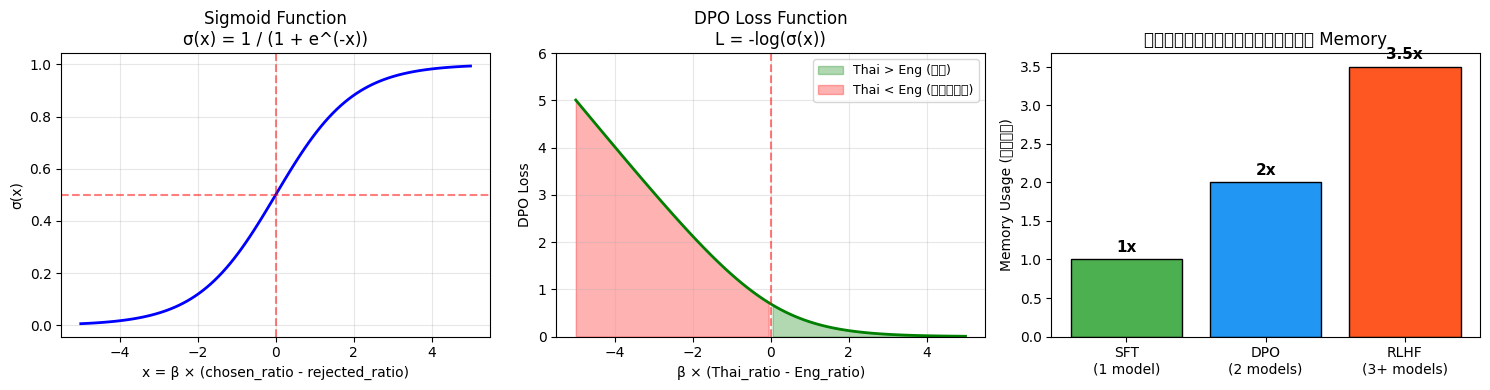


📊 คำอธิบาย:
- กราฟ 1: Sigmoid แปลงค่าให้อยู่ระหว่าง 0-1
- กราฟ 2: ยิ่ง Thai > Eng มาก ยิ่ง loss ต่ำ (ดี)
- กราฟ 3: DPO ใช้ memory 2 เท่า เพราะต้องโหลด 2 โมเดล


In [18]:
# Visualization: DPO Loss และ Sigmoid Function
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Sigmoid Function
x = np.linspace(-5, 5, 100)
sigmoid = 1 / (1 + np.exp(-x))
axes[0].plot(x, sigmoid, 'b-', linewidth=2)
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_xlabel('x = β × (chosen_ratio - rejected_ratio)', fontsize=10)
axes[0].set_ylabel('σ(x)', fontsize=10)
axes[0].set_title('Sigmoid Function\nσ(x) = 1 / (1 + e^(-x))', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 2. DPO Loss
dpo_loss = -np.log(sigmoid + 1e-10)
axes[1].plot(x, dpo_loss, 'g-', linewidth=2)
axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1].fill_between(x[x > 0], 0, dpo_loss[x > 0], alpha=0.3, color='green', label='Thai > Eng (ดี)')
axes[1].fill_between(x[x < 0], 0, dpo_loss[x < 0], alpha=0.3, color='red', label='Thai < Eng (ไม่ดี)')
axes[1].set_xlabel('β × (Thai_ratio - Eng_ratio)', fontsize=10)
axes[1].set_ylabel('DPO Loss', fontsize=10)
axes[1].set_title('DPO Loss Function\nL = -log(σ(x))', fontsize=12)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 6)

# 3. Memory Usage
methods = ['SFT\n(1 model)', 'DPO\n(2 models)', 'RLHF\n(3+ models)']
memory = [1, 2, 3.5]
colors = ['#4CAF50', '#2196F3', '#FF5722']
bars = axes[2].bar(methods, memory, color=colors, edgecolor='black')
axes[2].set_ylabel('Memory Usage (เท่า)', fontsize=10)
axes[2].set_title('เปรียบเทียบการใช้ Memory', fontsize=12)
for bar, mem in zip(bars, memory):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f'{mem}x', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('dpo_visualization.png', dpi=150)
plt.show()

print("\n📊 คำอธิบาย:")
print("- กราฟ 1: Sigmoid แปลงค่าให้อยู่ระหว่าง 0-1")
print("- กราฟ 2: ยิ่ง Thai > Eng มาก ยิ่ง loss ต่ำ (ดี)")
print("- กราฟ 3: DPO ใช้ memory 2 เท่า เพราะต้องโหลด 2 โมเดล")

In [19]:
def compute_log_probs(logits, labels, mask=None):
    """
    คำนวณ log probability ของ tokens
    """
    # Shift: logits[:-1] ทำนาย labels[1:]
    logits = logits[:, :-1, :]
    labels = labels[:, 1:]

    # Log softmax
    log_softmax = F.log_softmax(logits, dim=-1)

    # Gather log probs
    selected_log_probs = torch.gather(
        log_softmax,
        dim=-1,
        index=labels.unsqueeze(-1)
    ).squeeze(-1)

    if mask is not None:
        mask = mask[:, 1:]
        selected_log_probs = selected_log_probs * mask
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1).clamp(min=1)
    else:
        avg_log_prob = selected_log_probs.mean(-1)

    return avg_log_prob

In [20]:
def compute_dpo_loss(policy_model, reference_model, batch, beta=0.1):
    """
    คำนวณ DPO Loss

    Parameters:
    -----------
    policy_model: Qwen3Model - โมเดลที่จะ train
    reference_model: Qwen3Model - โมเดลอ้างอิง (frozen)
    batch: dict - Batch ของข้อมูล
    beta: float - Temperature parameter

    Returns:
    --------
    loss, chosen_reward, rejected_reward
    """
    chosen = batch["chosen"]
    rejected = batch["rejected"]
    chosen_mask = batch["chosen_mask"]
    rejected_mask = batch["rejected_mask"]

    # Forward pass - Policy model
    policy_chosen_logits = policy_model(chosen)
    policy_rejected_logits = policy_model(rejected)

    # Forward pass - Reference model (no gradient)
    with torch.no_grad():
        ref_chosen_logits = reference_model(chosen)
        ref_rejected_logits = reference_model(rejected)

    # คำนวณ log probs
    policy_chosen_log_probs = compute_log_probs(policy_chosen_logits, chosen, chosen_mask)
    policy_rejected_log_probs = compute_log_probs(policy_rejected_logits, rejected, rejected_mask)
    ref_chosen_log_probs = compute_log_probs(ref_chosen_logits, chosen, chosen_mask)
    ref_rejected_log_probs = compute_log_probs(ref_rejected_logits, rejected, rejected_mask)

    # Log ratios
    chosen_log_ratio = policy_chosen_log_probs - ref_chosen_log_probs
    rejected_log_ratio = policy_rejected_log_probs - ref_rejected_log_probs

    # DPO Loss
    logits = beta * (chosen_log_ratio - rejected_log_ratio)
    loss = -F.logsigmoid(logits).mean()

    # Rewards for monitoring
    chosen_reward = chosen_log_ratio.mean().detach()
    rejected_reward = rejected_log_ratio.mean().detach()

    return loss, chosen_reward, rejected_reward

---
## 7. ฝึกโมเดลด้วย DPO

### 7.1 โหลด Qwen3-0.6B Pre-trained Weights

In [21]:
print("="*60)
print("กำลังดาวน์โหลด Qwen3-0.6B weights...")
print("="*60)

# Download weights
weights = download_from_huggingface_from_snapshots(
    repo_id=REPO_ID,
    local_dir=LOCAL_DIR
)

print(f"\n✅ Downloaded {len(weights)} weight tensors")

/Users/kobkrit/miniconda3/envs/thai_preference-tuning-with-dpo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


กำลังดาวน์โหลด Qwen3-0.6B weights...


Fetching 10 files: 100%|██████████| 10/10 [00:00<00:00, 5810.89it/s]



✅ Downloaded 311 weight tensors


In [22]:
print("กำลังสร้าง Policy Model...")
policy_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(policy_model, QWEN_CONFIG_06_B, weights)
policy_model.to(device)

print("กำลังสร้าง Reference Model...")
reference_model = Qwen3Model(QWEN_CONFIG_06_B)
load_weights_into_qwen(reference_model, QWEN_CONFIG_06_B, weights)
reference_model.to(device)

# Freeze reference model
for param in reference_model.parameters():
    param.requires_grad = False

# Count parameters
total_params = sum(p.numel() for p in policy_model.parameters())
trainable_params = sum(p.numel() for p in policy_model.parameters() if p.requires_grad)

print(f"\n✅ โมเดลโหลดเสร็จ!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n⚠️ หมายเหตุ: ใช้ memory ~{total_params * 4 / 1e9:.1f} GB (2 โมเดล × BF16)")

กำลังสร้าง Policy Model...
กำลังสร้าง Reference Model...

✅ โมเดลโหลดเสร็จ!
Total parameters: 751,632,384
Trainable parameters: 751,632,384

⚠️ หมายเหตุ: ใช้ memory ~3.0 GB (2 โมเดล × BF16)


### 7.2 ทดสอบโมเดลก่อน DPO (Baseline)

ก่อนที่จะ train ด้วย DPO เรามาทดสอบดูก่อนว่า **โมเดล Qwen3-0.6B ดั้งเดิม** ตอบคำถามภาษาไทยอย่างไร

เราจะใช้คำถามชุดเดียวกันกับที่จะทดสอบหลัง DPO เพื่อเปรียบเทียบผลลัพธ์

In [23]:
def generate_response(model, tokenizer, prompt, max_new_tokens=200, temperature=0.6):
    """
    สร้างคำตอบจาก Qwen3
    """
    model.eval()

    # Format prompt
    formatted = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(formatted, chat_wrapped=False)
    input_tensor = torch.tensor([input_ids]).to(device)

    # Generate
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(input_tensor)
            logits = logits[:, -1, :] / temperature

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            input_tensor = torch.cat([input_tensor, next_token], dim=1)

            # Stop at EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

    output = tokenizer.decode(input_tensor[0].tolist())
    return output

In [24]:
# คำถามทดสอบ (จะใช้ชุดเดียวกันหลัง DPO)
test_prompts = [
    "อธิบายว่า Machine Learning คืออะไร",
    "วิธีการดูแลสุขภาพที่ดี",
    "ประเทศไทยมีกี่จังหวัด"
]

print("="*60)
print("🔵 ทดสอบ Qwen3-0.6B ก่อน DPO (Baseline)")
print("="*60)

baseline_responses = []
for i, prompt in enumerate(test_prompts):
    print(f"\n📝 คำถาม {i+1}: {prompt}")
    print("-"*40)
    response = generate_response(policy_model, tokenizer, prompt, max_new_tokens=150)
    baseline_responses.append(response)
    print(response)
    print("-"*40)

print("\n⚠️ สังเกต: โมเดลอาจตอบเป็นภาษาอังกฤษหรือผสมภาษา")

🔵 ทดสอบ Qwen3-0.6B ก่อน DPO (Baseline)

📝 คำถาม 1: อธิบายว่า Machine Learning คืออะไร
----------------------------------------
<|im_start|>user
อธิบายว่า Machine Learning คืออะไร<|im_end|>
<|im_start|>assistant
<think>
Okay, so the user is asking about what Machine Learning is. Let me start by breaking down the basics. I know that Machine Learning is a subset of artificial intelligence, right? It's about building systems that can learn from data rather than being told specific information. 

First, I should define it clearly. Maybe start with the key terms: data, models, algorithms. Then explain that the goal is to let the model learn from data to make predictions or decisions. But I need to make sure it's not too technical. Maybe mention real-world examples like image recognition or recommendation systems.

Wait, the user might not be familiar with the concepts. I should explain it step by step. Start with the basics, then go into how it
----------------------------------------

📝 คำถ

### 7.3 Training Loop

In [25]:
def train_dpo(
    policy_model,
    reference_model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=3,
    beta=0.1,
    eval_freq=10
):
    """
    Training loop สำหรับ DPO
    """
    train_losses, val_losses, reward_margins = [], [], []
    global_step = 0

    for epoch in range(num_epochs):
        policy_model.train()
        epoch_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            optimizer.zero_grad()

            loss, chosen_reward, rejected_reward = compute_dpo_loss(
                policy_model, reference_model, batch, beta=beta
            )

            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            reward_margin = chosen_reward.item() - rejected_reward.item()

            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'margin': f'{reward_margin:.4f}'
            })

            global_step += 1

            if global_step % eval_freq == 0:
                val_loss = evaluate_dpo(policy_model, reference_model, val_loader, beta)
                train_losses.append(loss.item())
                val_losses.append(val_loss)
                reward_margins.append(reward_margin)

        avg_loss = epoch_loss / len(train_loader)
        print(f"\nEpoch {epoch+1}: Average Loss = {avg_loss:.4f}")

    return {'train_losses': train_losses, 'val_losses': val_losses, 'reward_margins': reward_margins}


def evaluate_dpo(policy_model, reference_model, val_loader, beta=0.1):
    policy_model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            loss, _, _ = compute_dpo_loss(policy_model, reference_model, batch, beta=beta)
            total_loss += loss.item()

    policy_model.train()
    return total_loss / len(val_loader)

In [26]:
# ตั้งค่า Optimizer
optimizer = torch.optim.AdamW(
    policy_model.parameters(),
    lr=5e-6,
    weight_decay=0.01
)

print("Optimizer: AdamW")
print("Learning Rate: 5e-6")
print("Beta (DPO): 0.1")

Optimizer: AdamW
Learning Rate: 5e-6
Beta (DPO): 0.1


In [27]:
# เริ่ม Training
print("="*60)
print("เริ่ม DPO Training with Qwen3-0.6B")
print("="*60)

history = train_dpo(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=2,
    beta=0.1,
    eval_freq=5
)

เริ่ม DPO Training with Qwen3-0.6B


Epoch 1/2: 100%|██████████| 35/35 [01:48<00:00,  3.10s/it, loss=0.6920, margin=0.0231]



Epoch 1: Average Loss = 0.6917


Epoch 2/2: 100%|██████████| 35/35 [01:50<00:00,  3.17s/it, loss=0.6763, margin=0.3406]


Epoch 2: Average Loss = 0.6863


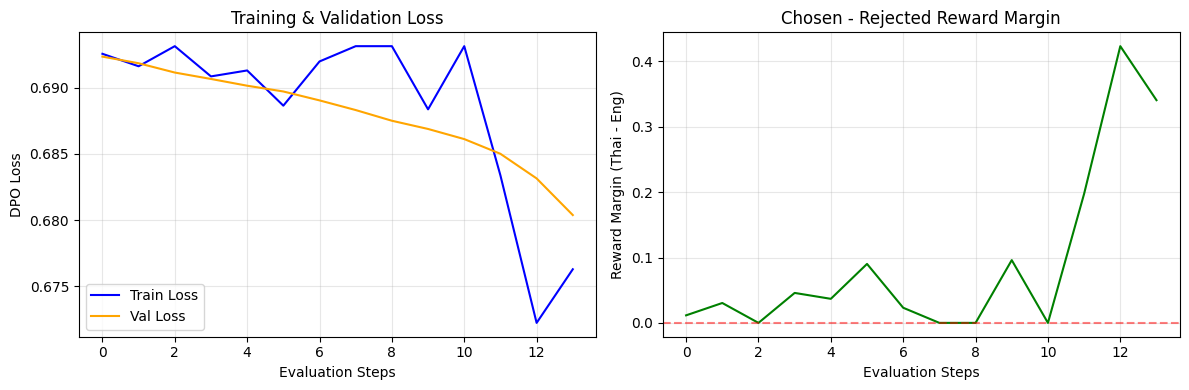


📊 กราฟแสดง:
- Loss ควรลดลง
- Reward Margin ควรเพิ่มขึ้น (Thai > Eng)


In [28]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_losses'], label='Train Loss', color='blue')
axes[0].plot(history['val_losses'], label='Val Loss', color='orange')
axes[0].set_xlabel('Evaluation Steps')
axes[0].set_ylabel('DPO Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['reward_margins'], color='green')
axes[1].set_xlabel('Evaluation Steps')
axes[1].set_ylabel('Reward Margin (Thai - Eng)')
axes[1].set_title('Chosen - Rejected Reward Margin')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dpo_training_curves.png', dpi=150)
plt.show()

print("\n📊 กราฟแสดง:")
print("- Loss ควรลดลง")
print("- Reward Margin ควรเพิ่มขึ้น (Thai > Eng)")

---
## 8. ทดสอบผลลัพธ์

In [29]:
# ทดสอบกับคำถามภาษาไทยหลัง DPO (ใช้คำถามเดียวกัน)
print("="*60)
print("🟢 ทดสอบ Qwen3-0.6B หลัง DPO Training")
print("="*60)

for i, prompt in enumerate(test_prompts):
    print(f"\n📝 คำถาม {i+1}: {prompt}")
    print("-"*40)
    response = generate_response(policy_model, tokenizer, prompt, max_new_tokens=150)
    print(response)
    print("-"*40)

print("\n✅ สังเกต: โมเดลควรตอบเป็นภาษาไทยมากขึ้นหลัง DPO")

🟢 ทดสอบ Qwen3-0.6B หลัง DPO Training

📝 คำถาม 1: อธิบายว่า Machine Learning คืออะไร
----------------------------------------
<|im_start|>user
อธิบายว่า Machine Learning คืออะไร<|im_end|>
<|im_start|>assistant
<think>

</think>

Machine Learning (ML) คือกระบวนการประมวลผลข้อมูลที่ใช้เพื่อให้ระบบหรือเครื่องมือสามารถเรียนรู้จากข้อมูลที่มีอยู่และปรึกษาตัวละครที่สามารถทำได้โดยใช้ข้อมูลนั้น โดยไม่ต้องพึ่งพาข้อมูลที่มีไว้ร่วมกันกับเครื่องมือนั้น ซึ่งหมายความว่าระบบสามารถปรับปรุงตนเองได้ตามข้อมูลที่เกิดขึ้นมา ซึ่งช่วยให้การ
----------------------------------------

📝 คำถาม 2: วิธีการดูแลสุขภาพที่ดี
----------------------------------------
<|im_start|>user
วิธีการดูแลสุขภาพที่ดี<|im_end|>
<|im_start|>assistant
<think>
ข้อความที่ต้องการให้แสดงวิธีการดูแลสุขภาพที่ดี แต่มีข้อความที่ไม่ถูกต้อง อาจหมายความว่าคุณต้องการให้แสดงข้อมูลที่ถูกต้อง แต่ไม่ได้ระบุ đầy đủ โปรดให้ข้อมูลเพิ่มเติมเพื่อให้คำตอบถูกต้อง
</think>

หากคุณต้องการให้แสดงข้อมูลวิธีดูแลสุขภาพที่ดี แต่มีข้อความไม่ถูกต้อง อาจหมาย
----------

---
## สรุป

### สิ่งที่เราได้เรียนรู้:

1. **DPO คืออะไร**: เทคนิคการจัดแนว LLM กับความชอบของมนุษย์

2. **Qwen3-0.6B**: โมเดลที่รองรับภาษาไทยและ Thinking Mode

3. **Memory Requirements**: DPO ใช้ memory 2 เท่าเพราะต้องโหลด 2 โมเดล

4. **DPO Loss**: ทำให้โมเดลชอบ chosen (ภาษาไทย) มากกว่า rejected (ภาษาอังกฤษ)

### Use Case ในบทเรียนนี้:

- **Chosen**: คำตอบภาษาไทย + `<think>` reasoning
- **Rejected**: คำตอบภาษาอังกฤษ (ผิดภาษา)
- **ผลลัพธ์**: โมเดลเรียนรู้ที่จะตอบเป็นภาษาไทยเมื่อถูกถามเป็นภาษาไทย

---

**อ้างอิง:**

- Raschka, Sebastian. *Build A Large Language Model (From Scratch)*. Manning, 2024. ISBN: 978-1633437166.
- Rafailov et al. "Direct Preference Optimization: Your Language Model is Secretly a Reward Model" NeurIPS 2023.
- https://github.com/rasbt/LLMs-from-scratch
- https://huggingface.co/Qwen/Qwen3-0.6B

---

**แปลและปรับปรุงโดย:** Kobkrit Viriyayudhakorn (กอบกฤตย์ วิริยะยุทธกร) | kobkrit@iapp.co.th | iApp Technology Co., Ltd.